In [1]:

import os
import itertools

import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
PLOTS_DIR = os.path.join(os.getcwd(),"plots")
MODEL_SAVE_DIR = os.path.join(os.getcwd(),"saved_models")
LOG_DIR = os.path.join(os.getcwd(),"logs")

if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

In [3]:
df = pd.read_csv(r'Data\creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def preprocess_data(data):
    data = data.drop(['Time'], axis=1)
    data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
    return data

In [8]:
data = preprocess_data(df)

In [9]:
def get_train_and_test_data(processed_data):
    X_train, X_test = train_test_split(processed_data, test_size=0.25,random_state=0)
    X_train = X_train[X_train.Class == 0]
    X_train = X_train.drop(['Class'], axis=1)
    y_test = X_test['Class']
    X_test = X_test.drop(['Class'], axis=1)
    X_train = X_train.values
    X_test = X_test.values
    return X_train, X_test,y_test


In [10]:
X_train, X_test,y_test = get_train_and_test_data(data)

In [20]:
X_train.shape, X_test.shape,y_test.shape

((213233, 29), (71202, 29), (71202,))

In [11]:

input = layers.Input(shape=(X_train.shape[1],))
layer_encoder = layers.Dense(14, activation="tanh",activity_regularizer=keras.regularizers.l1(10e-5))(input)
layer_encoder = layers.Dense(7,activation="relu")(layer_encoder)
layer_decoder = layers.Dense(7,activation='tanh')(layer_encoder)
layer_decoder = layers.Dense(X_train.shape[1], activation='relu')(layer_decoder)
autoencoder = keras.Model(inputs=input, outputs=layer_decoder)

In [12]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR,
"trained_model.h5"), verbose=0, save_best_only=True)

log_tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True,
                                write_images=True)

In [13]:
EPOCHS = 100
BATCH_SIZE = 32
history = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                shuffle=True, validation_data=(X_test, X_test),verbose=1,
                callbacks=[checkpoint, log_tensorboard])

Epoch 1/100
6664/6664 [==============================] - 13s 2ms/step - loss: 0.8007 - accuracy: 0.5825 - val_loss: 0.7923 - val_accuracy: 0.6497
Epoch 2/100
6664/6664 [==============================] - 13s 2ms/step - loss: 0.7292 - accuracy: 0.6661 - val_loss: 0.7707 - val_accuracy: 0.6705
Epoch 3/100
6664/6664 [==============================] - 13s 2ms/step - loss: 0.7151 - accuracy: 0.6787 - val_loss: 0.7597 - val_accuracy: 0.6843
Epoch 4/100
6664/6664 [==============================] - 12s 2ms/step - loss: 0.7084 - accuracy: 0.6833 - val_loss: 0.7555 - val_accuracy: 0.6841
Epoch 5/100
6664/6664 [==============================] - 12s 2ms/step - loss: 0.7041 - accuracy: 0.6883 - val_loss: 0.7540 - val_accuracy: 0.6921
Epoch 6/100
6664/6664 [==============================] - 13s 2ms/step - loss: 0.7016 - accuracy: 0.6955 - val_loss: 0.7495 - val_accuracy: 0.6998
Epoch 7/100
6664/6664 [==============================] - 12s 2ms/step - loss: 0.6997 - accuracy: 0.7016 - val_loss: 0.7529 -

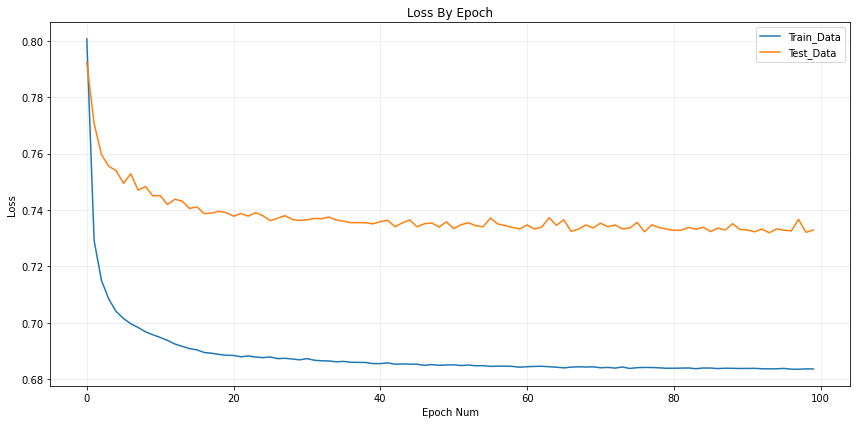

In [15]:
fig = plt.figure(num="Loss Curves")
fig.set_size_inches(12, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss By Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch Num')
plt.legend(['Train_Data', 'Test_Data'], loc='upper right')
plt.grid(True, alpha=.25)
plt.tight_layout()

In [16]:
trained_model = keras.models.load_model(os.path.join(MODEL_SAVE_DIR,'trained_model.h5'))

In [17]:
test_predictions = trained_model.predict(X_test)

In [19]:
test_predictions.shape

(71202, 29)

In [21]:

mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
reconstruction_error = pd.DataFrame({'recon_error': mse,
                                 'true_class': y_test})

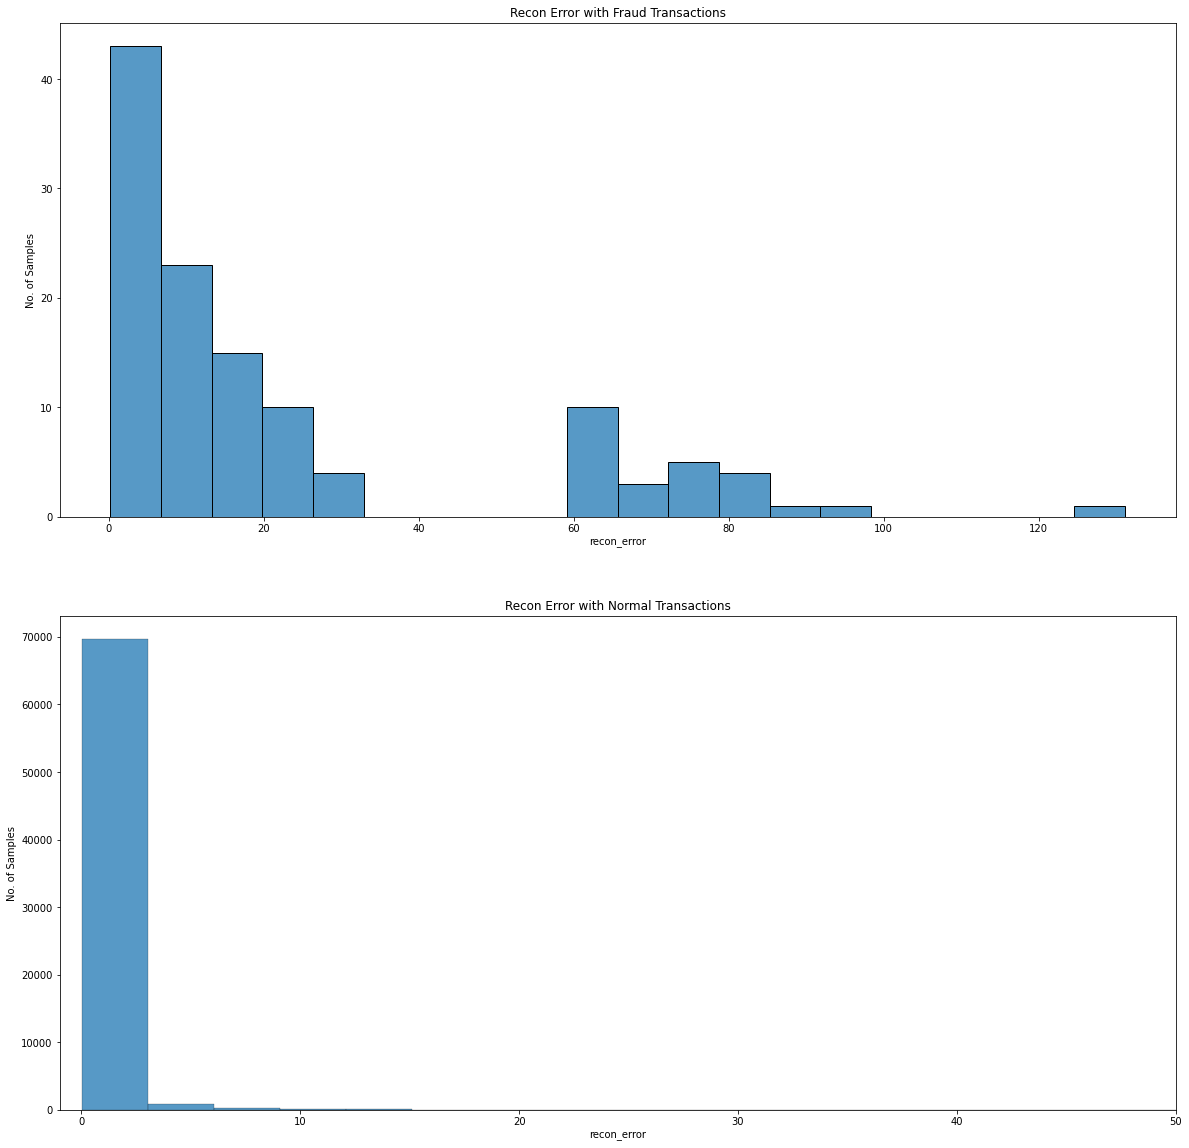

In [39]:
fig , (ax1, ax2) = plt.subplots(2,1,figsize = (20,20))
sns.histplot(data = reconstruction_error[y_test == 1],x= 'recon_error',bins = 20,ax = ax1)
ax1.set_title("Recon Error with Fraud Transactions")
ax1.set_ylabel('No. of Samples')
sns.histplot(data = reconstruction_error[y_test == 0],x= 'recon_error',bins = 500,ax = ax2)
ax2.set_title("Recon Error with Normal Transactions")
ax2.set_ylabel('No. of Samples')
ax2.set_xlim(-1,50)
plt.show()

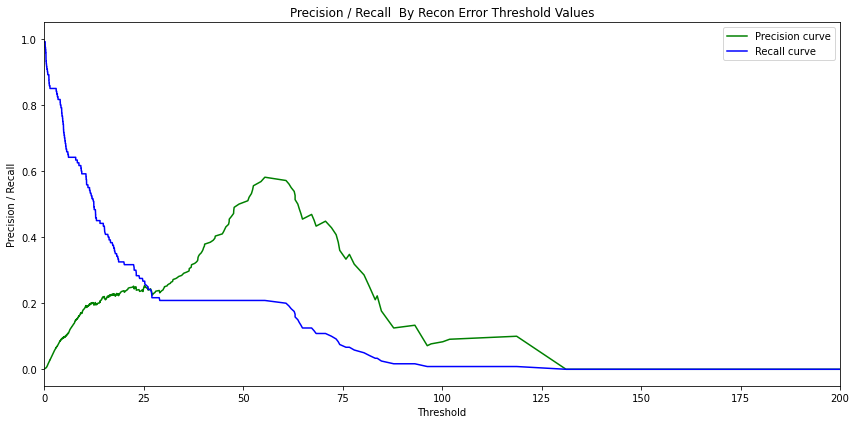

In [43]:
precision, recall, threshold = precision_recall_curve(reconstruction_error.true_class,reconstruction_error.recon_error)
# Plotting the precision curve
fig = plt.figure(num ="Precision Curve")
fig.set_size_inches(12, 6)
plt.plot(threshold, precision[1:], 'g', label='Precision curve')
plt.title('Precision / Recall  By Recon Error Threshold Values')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.xlim(0,200)
plt.tight_layout()
image_name = 'Precision_Threshold_Curve.png'
fig.savefig(os.path.join(PLOTS_DIR, image_name), dpi=fig.dpi)

plt.plot(threshold, recall[1:], 'b', label='Recall curve')
image_name = 'Recall_Threshold_Curve.png'
fig.savefig(os.path.join(PLOTS_DIR, image_name), dpi=fig.dpi)
plt.legend()

plt.show()


In [62]:
idx = list(filter(lambda x: x[1] > min_recall, enumerate(recall[1:])))[-1][0]
threshold[idx]

4.072859271931941

Min recall is : 0.808333, Threshold for recon error is: 4.072859 


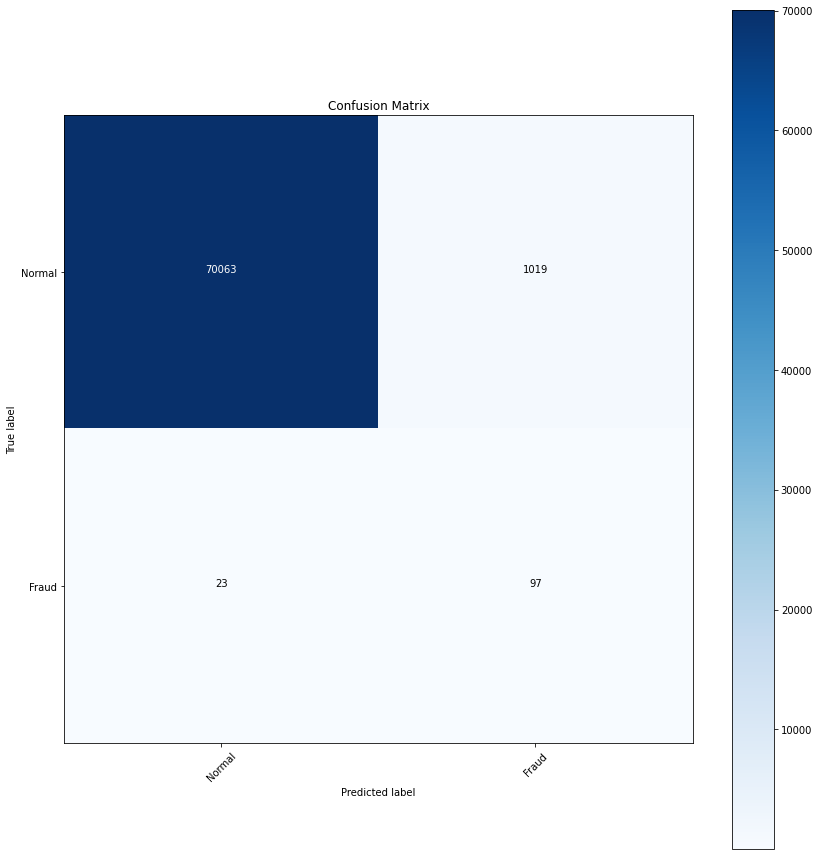

In [64]:
 # Get the confusion matrix with min desired recall on the testing dataset used.
min_recall = 0.8

precision, recall, threshold = precision_recall_curve(reconstruction_error.true_class,reconstruction_error.recon_error)
idx = list(filter(lambda x: x[1] > min_recall, enumerate(recall[1:])))[-1][0]
th = threshold[idx]
print ("Min recall is : %f, Threshold for recon error is: %f " %(recall[idx+1], th))

# Get the confusion matrix
predicted_class = [1 if e > th else 0 for e in reconstruction_error.recon_error.values]
cnf_matrix = confusion_matrix(reconstruction_error.true_class, predicted_class)
classes = ['Normal','Fraud']

fig = plt.figure(figsize=(12, 12))
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
image_name = 'Confusion_Matrix_with_threshold_{}.png'.format(th)
fig.savefig(os.path.join(PLOTS_DIR, image_name), dpi=fig.dpi)
